In [1]:
# Fit a RHESSI microflare spectra (attenuator out) using the
# new v11.02 N_T=101 CHIANTI database files
# 
# 13-Aug-2025 IGH


In [4]:
from astropy.time import Time, TimeDelta
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from sunpy.io.special import read_genx
# Using sunkit-spex 0.4.1.dev48+gab0189e
from sunkit_spex.legacy import thermal
from sunkit_spex.extern.rhessi import RhessiLoader
from sunkit_spex.legacy.fitting.fitter import Fitter


import warnings
warnings.filterwarnings("ignore", category=RuntimeWarning) 

In [5]:
plt.rcParams.update({'font.size': 18,'font.family':"sans-serif",\
                         'font.sans-serif':"Arial",'mathtext.default':"regular"})

In [6]:
# Load in the new thermal model CHIANTI files
# Updated lines but also lower resolution temperature binning
thermal.CONTINUUM_GRID=thermal.setup_continuum_parameters('chianti_cont_1_250_unity_v1102_t101.sav')
# Just using >2 keV file since RHESSI data starts at 1 keV
thermal.LINE_GRID=thermal.setup_line_parameters('chianti_lines_2_12_unity_v1102_t101.sav')

In [7]:
# Return a string with a trailing 0 if <10
def ldz_int(num):
    if num<10:
        return f'0{int(num):d}'
    if num >=10:
        return f'{int(num):d}'
# Convert astropy time into break_time sswidl format used for the filenames
def break_time(time):
    t=time.ymdhms
    stime=f'{t.year:d}'+ldz_int(t.month)+ldz_int(t.day)+'_'+\
        ldz_int(t.hour)+ldz_int(t.minute)+ldz_int(t.second)
    return stime

In [8]:
# Use the genx file info for the times and the filename

fname='20030725_082642'
btims=[Time('2003-07-25T08:22:54',format='isot'), Time('2003-07-25T08:23:10',format='isot')]
ftims=[Time('2003-07-25T08:26:34.000',format='isot'), Time('2003-07-25T08:26:50.000',format='isot')]


In [9]:
# Some setup for sunxspex
time_profile_size = (9,6)
spec_single_plot_size = (6,8)
spec_plot_size = (16,10)
spec_font_size = 18
default_font_size = 10
xlims, ylims = [3,30], [5e-2,3e4]
tol = 1e-5

_dir = "../../rhessi_spectra/mfstats9_fits/"

In [10]:
# use the summed over 6 detectors
spec = Fitter(pha_file=_dir+fname+"_spec_sum_org.fits", 
                srm_file=_dir+fname+"_srm_sum_org.fits")

In [ ]:
rhess_spec = RhessiLoader(spectrum_fn=_dir+fname+"_spec_sum_org.fits", srm_fn=_dir+fname+"_srm_sum_org.fits")
# background time
rhess_spec.update_background_times(btims[0],btims[1])
# event time
rhess_spec.update_event_times(ftims[0],ftims[1])

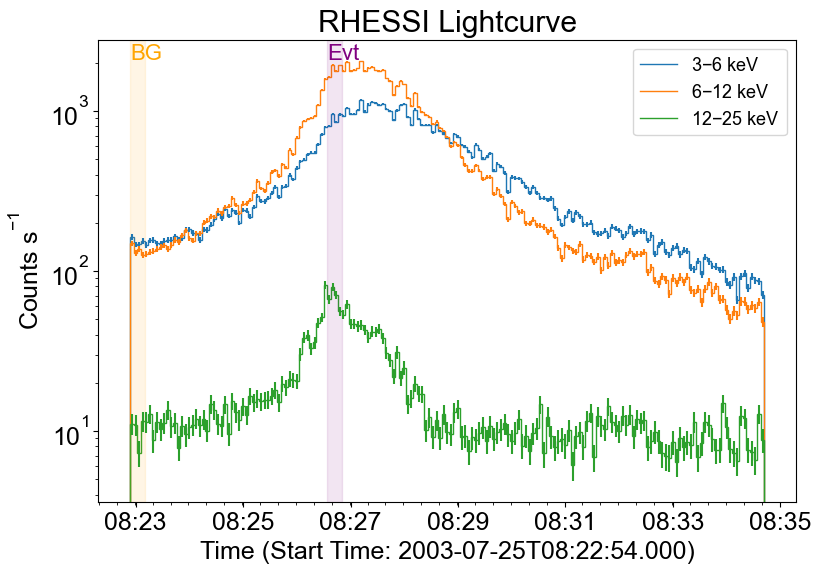

In [19]:
plt.rcParams['font.size'] = spec_font_size
plt.figure(figsize=time_profile_size)
rhess_spec.update_background_times(btims[0],btims[1])
rhess_spec.update_event_times(ftims[0],ftims[1])
ax=rhess_spec.lightcurve(energy_ranges=[[3,6], [6,12], [12,25]])
# ax.set_xlim(tr[0].datetime,tr[1].datetime)
# ax.set_xlabel("Start Time "+tr[0].iso[:19])
ax.xaxis.set_minor_locator(matplotlib.dates.SecondLocator(interval=20))
ax.xaxis.set_major_locator(matplotlib.dates.MinuteLocator(interval=2))
ax.xaxis.set_major_formatter(matplotlib.dates.DateFormatter('%H:%M'))
plt.show()

In [20]:
fitter = Fitter(rhess_spec)
fitter.model = "(f_vth+thick_fn)"
fitter.loglikelihood = "cstat"

In [21]:
# Just fit thermal part first and set the bounds
spec.energy_fitting_range = [4,8]
fitter.params["T1_spectrum1"] = {"Value":10, "Bounds":(7, 20)}
fitter.params["EM1_spectrum1"] = {"Value":1, "Bounds":(1e-2, 1e2)}
fitter.params["total_eflux1_spectrum1"] = {"Status":"fix", "Value":0.9, "Bounds":(1e-2, 1e2)}
fitter.params["index1_spectrum1"] = {"Status":"fix", "Value":6, "Bounds":(3, 12)}
fitter.params["e_c1_spectrum1"] = {"Status":"fix", "Value":15, "Bounds":(7, 30)}
spec_fit = fitter.fit()

# Then non-thermal fit higher energy
fitter.energy_fitting_range = [9,20]
fitter.params["T1_spectrum1"] = "fix"
fitter.params["EM1_spectrum1"] = "fix"
fitter.params["total_eflux1_spectrum1"] = "free"
fitter.params["index1_spectrum1"] = "free"
fitter.params["e_c1_spectrum1"] = "free"
spec_fit = fitter.fit()

# The do the full range
fitter.energy_fitting_range = [4,20]
fitter.params["T1_spectrum1"] = "free"
fitter.params["EM1_spectrum1"] = "free"
fitter.params["total_eflux1_spectrum1"] = "free"
fitter.params["index1_spectrum1"] = "free"
fitter.params["e_c1_spectrum1"] = "free"
spec_fit = fitter.fit()

In [22]:
print(fitter.params)

                       Status      Value         Bounds  \
T1_spectrum1             free  14.340729        (7, 20)   
EM1_spectrum1            free   1.670322  (0.01, 100.0)   
total_eflux1_spectrum1   free   2.860441  (0.01, 100.0)   
index1_spectrum1         free   6.530404        (3, 12)   
e_c1_spectrum1           free   8.635750        (7, 30)   

                                                             Error  
T1_spectrum1            (0.15999561387151282, 0.15999561387151282)  
EM1_spectrum1           (0.13383956319991516, 0.13383956319991516)  
total_eflux1_spectrum1    (0.6433894609040669, 0.6433894609040669)  
index1_spectrum1        (0.10938075545346987, 0.10938075545346987)  
e_c1_spectrum1          (0.34142413155699913, 0.34142413155699913)  


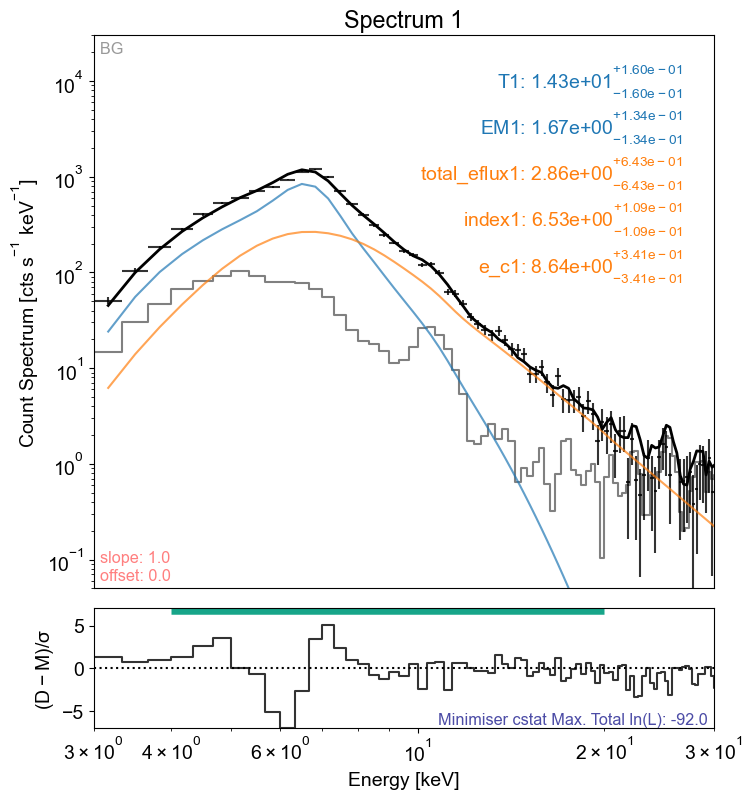

In [23]:
# Remember that sunxspex plots the background and data, 
# whereas ospex did background and data-background
# So total model black line is thermal+non-thermal+background

plt.rcParams['font.size'] = 14
plt.figure(figsize=[8,9])
axes, res_axes = fitter.plot()
for a in axes:
    a.set_xlim(xlims)
    a.set_ylim(ylims)
    a.set_xscale("log")
plt.show()

In [24]:
mcmc_result = fitter.run_mcmc(steps_per_walker=1000,walker_spread='mag_order')

100%|██████████| 1000/1000 [02:10<00:00,  7.64it/s]


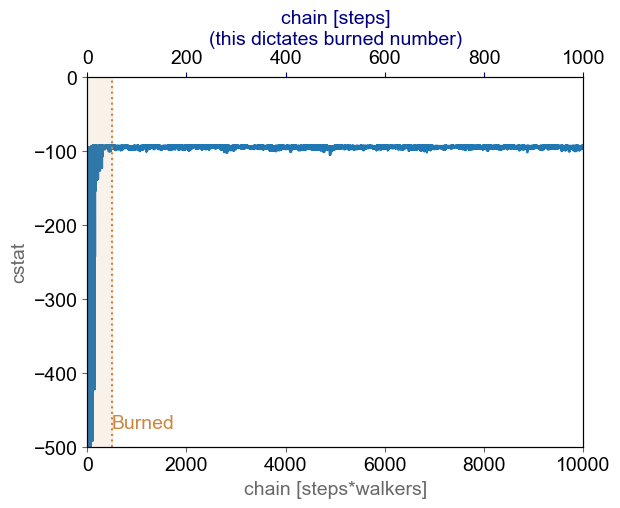

In [25]:
fitter.burn_mcmc = 50
plt.figure()
fitter.plot_log_prob_chain()
plt.ylim([-500,0])
plt.show()

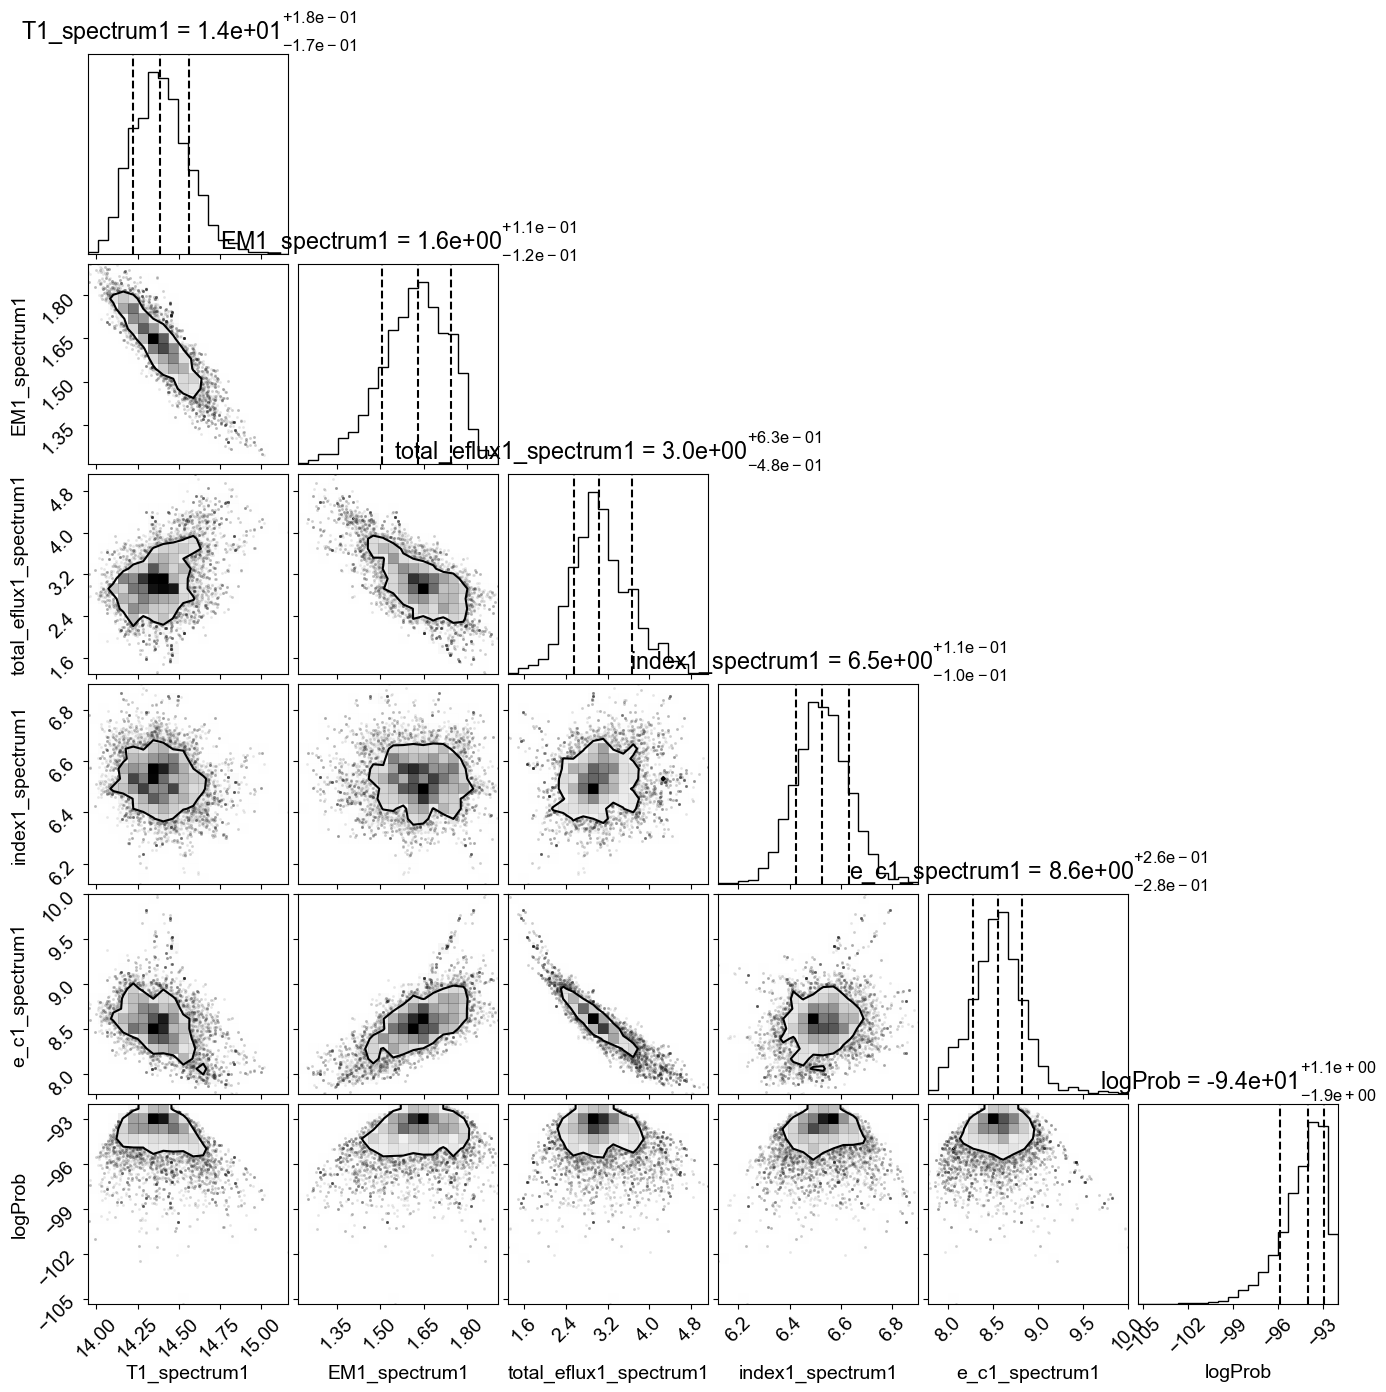

In [26]:
corner_plot = fitter.corner_mcmc()

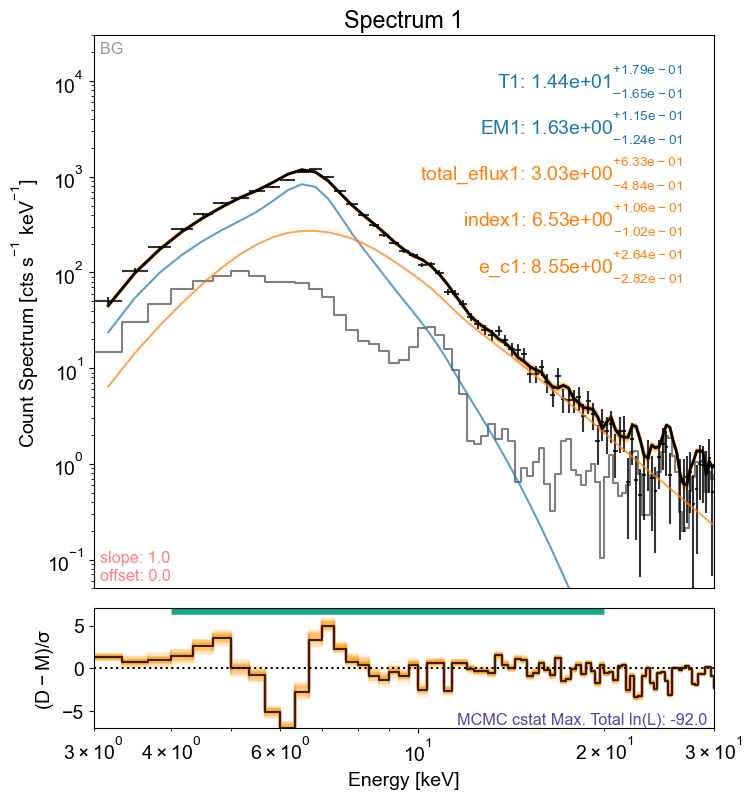

In [27]:
plt.rcParams['font.size'] = 14
plt.figure(figsize=[8,9])
axes, res_axes = fitter.plot()
for a in axes:
    a.set_xlim(xlims)
    a.set_ylim(ylims)
    a.set_xscale("log")
plt.show()

In [30]:
# Note this only work in the current version of sunxspex.....
# Get all the fit parameters
tmk=fitter.params["T1_spectrum1"]['Value']
tmk_ci=[tmk-fitter.params["T1_spectrum1"]['Error'][0],tmk+fitter.params["T1_spectrum1"]['Error'][1]]
em=fitter.params["EM1_spectrum1"]['Value']*1e46
em_ci=[em-fitter.params["EM1_spectrum1"]['Error'][0]*1e46,\
    em+fitter.params["EM1_spectrum1"]['Error'][1]*1e46]
ntot=fitter.params["total_eflux1_spectrum1"]["Value"]*1e35
ntot_err=[fitter.params["total_eflux1_spectrum1"]["Error"][0]*1e35,\
          fitter.params["total_eflux1_spectrum1"]["Error"][1]*1e35]
ind=fitter.params["index1_spectrum1"]["Value"]
ind_err=[fitter.params["index1_spectrum1"]["Error"][0],fitter.params["index1_spectrum1"]["Error"][1]]
ec=fitter.params["e_c1_spectrum1"]["Value"]
ec_err=[fitter.params["e_c1_spectrum1"]["Error"][0],fitter.params["e_c1_spectrum1"]["Error"][1]]

# Make them look nice for the plot
tmks=f'{tmk:4.2f}'
tmkups=f'{tmk_ci[1]-tmk:4.2f}'
tmkdns=f'{tmk-tmk_ci[0]:4.2f}'
ems=f'{em*1e-46:4.2f}'
emups=f'{(em_ci[1]-em)*1e-46:4.2f}'
emdns=f'{(em-em_ci[0])*1e-46:4.2f}'
nts=f'{ntot*1e-35:4.2f}'
ntups=f'{ntot_err[1]*1e-35:4.2f}'
ntdns=f'{ntot_err[0]*1e-35:4.2f}'
inds=f'{ind:4.2f}'
indups=f'{ind_err[1]:4.2f}'
inddns=f'{ind_err[0]:4.2f}'
ecs=f'{ec:4.2f}'
ecups=f'{ec_err[1]:4.2f}'
ecdns=f'{ec_err[0]:4.2f}'

# Get the data and fits to replot
engs=fitter.plotting_info['spectrum1']['count_channels']
edels=fitter.plotting_info['spectrum1']['count_channel_error']
rat=fitter.plotting_info['spectrum1']['count_rates']
erat=fitter.plotting_info['spectrum1']['count_rate_errors']
# Currently background returns same values twice ?!?!?! like resid
backrat=fitter.plotting_info['spectrum1']['background_rate'][::2]
resid=fitter.plotting_info['spectrum1']['residuals'][::2]
fmd=fitter.plotting_info['spectrum1']['count_rate_model']
sfmd=fitter.plotting_info['spectrum1']['submodels']
fiter=fitter.plotting_info['spectrum1']['fitting_range']
# Sort out the energy binning steps for plotting
stepe = list()
for i in range(len(engs)):
    stepe.append(engs[i] - edels[i])
stepe.append(engs[-1]+edels[-1])
ns=len(stepe)

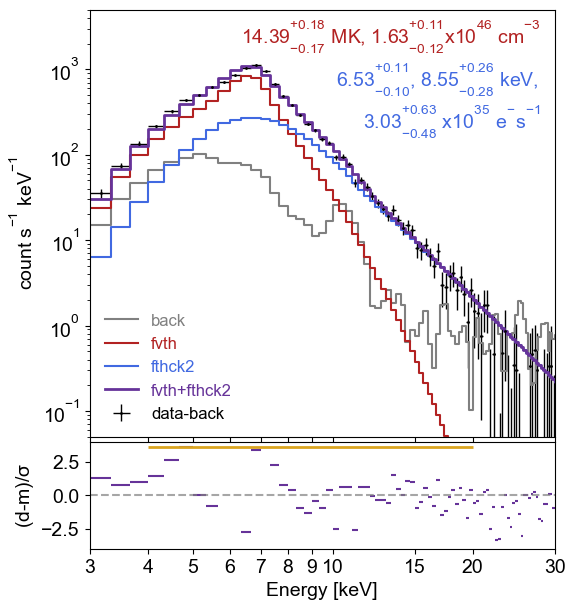

In [31]:
# Do the more standard plot of data-background
# Now do a nicer plot with x-axis log labels again
yrlim=[-4,4]
ylims=[5e-2,5e3]
xlim=[3,30]
gs_kw = dict(height_ratios=[4,1],hspace=0.02,wspace=0.05)
fig, axs = plt.subplots(ncols=1, nrows=2, constrained_layout=False,
                             gridspec_kw=gs_kw,figsize=(6,7))

axs[0].errorbar(engs,rat-backrat,xerr=edels,yerr=erat,fmt='.',color='k',lw=1.,ms=2,label='data-back')
axs[0].step(stepe[0:ns-1],backrat,where='post',color='grey',lw=1.5,label='back')
axs[0].step(stepe[0:ns-1],sfmd[0][0:ns-1],where='post',color='firebrick',label='fvth')
axs[0].step(stepe[0:ns-1],sfmd[1][0:ns-1],where='post',color='royalblue',label='fthck2')
axs[0].step(stepe[0:ns-1],sfmd[0][0:ns-1]+sfmd[1][0:ns-1],where='post',color='rebeccapurple',lw=2,label='fvth+fthck2')
axs[0].legend(loc=3,labelcolor='linecolor',frameon=False,prop={'size': 12})
axs[0].text(0.97,0.92,tmks+'$^{+'+tmkups+'}_{-'+tmkdns+'}$ MK, '+\
            ems+'$^{+'+emups+'}_{-'+emdns+'}$x10$^{46}$ cm$^{-3}$',\
              color='firebrick',ha='right',transform=axs[0].transAxes)

axs[0].text(0.97,0.82,inds+'$^{+'+indups+'}_{-'+inddns+'}$, '+\
            ecs+'$^{+'+ecups+'}_{-'+ecdns+'}$ keV, ',
              color='royalblue',ha='right',transform=axs[0].transAxes)
axs[0].text(0.97,0.72,nts+'$^{+'+ntups+'}_{-'+ntdns+'}$ x10$^{35}$ e$^{-}$s$^{-1}$',\
              color='royalblue',ha='right',transform=axs[0].transAxes)
axs[1].hlines(resid,stepe[0:-1],stepe[1:],color='rebeccapurple',lw=1.5)

axs[0].set_ylabel('count s$^{-1}$ keV$^{-1}$')
axs[0].set_xlabel(" ")
axs[0].set_yscale("log")
axs[0].set_ylim(ylims)

axs[1].set_ylabel("(d-m)/$\sigma$")
axs[1].set_ylim(yrlim)
axs[1].set_xlabel("Energy [keV]")
axs[1].hlines(0.0,xlims[0],xlims[1],color='grey',linestyle="--",alpha=0.7)
axs[1].hlines(yrlim[1]*0.9,fiter[0],fiter[1],color='goldenrod',lw=2)

for aaxx in axs:
    aaxx.set_xlim(xlim)
    aaxx.set_xscale("log")
    aaxx.set_xticks([3,4,5,6,7,8,9,10,15,20,30])
    aaxx.get_xaxis().set_major_formatter(matplotlib.ticker.ScalarFormatter())
axs[0].set_xticklabels([])
plt.savefig('sunkit_spex_'+fname+'.pdf',bbox_inches='tight')
plt.show()